# Imitation Agent

In [1]:
from pathlib import Path
import os
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import MeanAbsoluteError, Loss
from matplotlib import pyplot as plt
from torchsummary import summary

from ImitationAgent import ImitationAgent
import time

In [2]:
board = SummaryWriter(f'imitation-runs/imitation-model-{int(time.time())}')

In [43]:
VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
BATCH_SIZE = 2048  # Batch size for training
INPUT = 73  # The input size for model
OUTPUT = 1
DATA_PATH = Path('imitation data')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 1  # Number of epochs to train the model
# for Dave: might ask you to change the number of epochs
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train

agent = ImitationAgent(VAL_PERCENTAGE, TEST_NUM,
                          BATCH_SIZE, INPUT, OUTPUT, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'mse': MeanSquaredError(), 'loss': Loss(agent.criterion)
})

trainer.run(agent.train_loader, max_epochs=EPOCHS)

State:
	iteration: 104
	epoch: 1
	epoch_length: 104
	max_epochs: 1
	output: nan
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: torch.utils.data.dataloader.DataLoader
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
evaluator.run(agent.train_loader)
metrics = evaluator.state.metrics
avg_mse = metrics['mse']
avg_loss = metrics['loss']

Training - Epoch: 1 MAE: 0.16 Loss: 0.03
Validation - Epoch: 1 MAE: 0.16 Loss: 0.03
Training - Epoch: 2 MAE: 0.12 Loss: 0.02
Validation - Epoch: 2 MAE: 0.12 Loss: 0.02
Training - Epoch: 3 MAE: 0.09 Loss: 0.01
Validation - Epoch: 3 MAE: 0.09 Loss: 0.01
Training - Epoch: 4 MAE: 0.07 Loss: 0.01
Validation - Epoch: 4 MAE: 0.07 Loss: 0.01
Training - Epoch: 5 MAE: 0.05 Loss: 0.01
Validation - Epoch: 5 MAE: 0.05 Loss: 0.01
Training - Epoch: 6 MAE: 0.05 Loss: 0.01
Validation - Epoch: 6 MAE: 0.05 Loss: 0.01
Training - Epoch: 7 MAE: 0.04 Loss: 0.01
Validation - Epoch: 7 MAE: 0.04 Loss: 0.01
Training - Epoch: 8 MAE: 0.04 Loss: 0.01
Validation - Epoch: 8 MAE: 0.04 Loss: 0.01
Training - Epoch: 9 MAE: 0.04 Loss: 0.01
Validation - Epoch: 9 MAE: 0.04 Loss: 0.01
Training - Epoch: 10 MAE: 0.04 Loss: 0.01
Validation - Epoch: 10 MAE: 0.04 Loss: 0.01
Training - Epoch: 11 MAE: 0.04 Loss: 0.01
Validation - Epoch: 11 MAE: 0.04 Loss: 0.01
Training - Epoch: 12 MAE: 0.04 Loss: 0.01
Validation - Epoch: 12 MAE: 0.

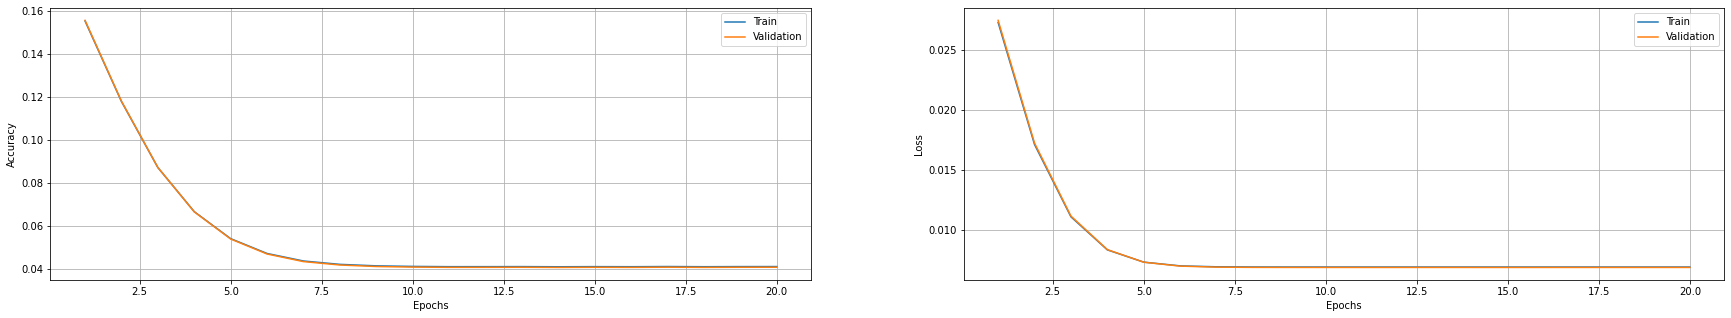

In [3]:
VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
BATCH_SIZE = 2048  # Batch size for training
INPUT = 73  # The input size for model
OUTPUT = 1
DATA_PATH = Path('imitation data')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 20  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train

agent = ImitationAgent(VAL_PERCENTAGE, TEST_NUM,
                          BATCH_SIZE, INPUT, OUTPUT, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'mae': MeanAbsoluteError(), 'loss': Loss(agent.criterion)
})


train_mae = []
validation_mae = []
train_loss = []
validation_loss = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_mae = metrics['mae']
    avg_loss = metrics['loss']
    train_mae.append(avg_mae)
    train_loss.append(avg_loss)
    board.add_scalar('MAE/Training MAE by Epoch', avg_mae, engine.state.epoch)
    board.add_scalar('Loss/Training Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Training - Epoch: {} MAE: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_mae, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_mae = metrics['mae']
    avg_loss = metrics['loss']
    validation_mae.append(avg_mae)
    validation_loss.append(avg_loss)
    board.add_scalar('MAE/Validation MAE by Epoch', avg_mae, engine.state.epoch)
    board.add_scalar('Loss/Validation Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Validation - Epoch: {} MAE: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_mae, avg_loss))


# Print summary of the model
# summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# Save the model's weights after training is complete
torch.save(agent.model.state_dict(), 'imitation-models/model1.pt') # change number if re-running!!!!!


plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_mae)) + 1, train_mae, label='Train')
plt.plot(np.arange(len(validation_mae)) + 1, validation_mae,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train')
plt.plot(np.arange(len(validation_loss)) + 1, validation_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

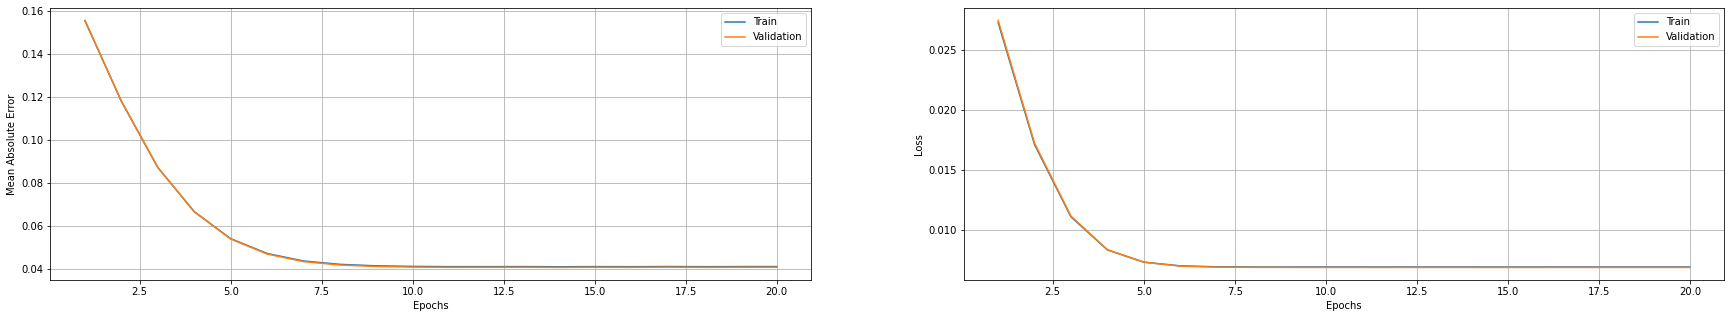

In [4]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_mae)) + 1, train_mae, label='Train')
plt.plot(np.arange(len(validation_mae)) + 1, validation_mae,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train')
plt.plot(np.arange(len(validation_loss)) + 1, validation_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()